In [1]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cftime
import dask
import xarrayutils
import cartopy.crs as ccrs
from xmip.preprocessing import combined_preprocessing
from xmip.preprocessing import replace_x_y_nominal_lat_lon
from xmip.drift_removal import replace_time
from xmip.postprocessing import concat_experiments
import xmip.drift_removal as xm_dr
import xmip as xm
import xesmf as xe
import datetime
from dateutil.relativedelta import relativedelta
import utils
import cf_xarray as cfxr

from sklearn.linear_model import LinearRegression
import scipy.signal as signal
from scipy import stats
from datetime import timedelta

import seaborn as sns
import matplotlib as mpl
import cmocean
import cmocean.cm as cmo
from matplotlib.gridspec import GridSpec

from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

import string
alphabet = list(string.ascii_lowercase)       

In [2]:
dask.config.set(**{'array.slicing.split_large_chunks': True})

# Import data

## Green's Function

In [3]:
G_ds_path = 'Outputs/G_pulse_ds.nc4'
G_cdr_ds_path = 'Outputs/G_cdr_ds.nc4'

G_ds = utils.import_polyfit_G(G_ds_path, G_cdr_ds_path)

## Convolution

In [4]:
conv_mean_ds = xr.open_dataset('Outputs/conv_mean_ds.nc4')['__xarray_dataarray_variable__']

conv_ds = xr.open_dataset('Outputs/conv_ds.nc4')['__xarray_dataarray_variable__']

## CMIP6 1pct

In [5]:
ds_dif = xr.open_dataset('Outputs/ds_dif.nc4')

## Emissions profile

In [6]:
emis_profile = xr.open_dataset('Outputs/emis_profile.nc4')


## RTCRE

In [7]:
RTCRE = xr.open_dataset('Outputs/RTCRE.nc')

# Settings and Define our Model Weights

In [8]:
#define our weights for models (grouping UKESM and CANESM realizations)
model_weights = utils.model_weights

onepct_model_weights = utils.onepct_model_weights

G_model_weights = utils.G_model_weights

In [9]:
type_color = utils.type_color

In [10]:
A = utils.A
ds_out = utils.ds_out

# Multiple options for path to 2 degrees C

In [11]:
T = 69 #years to 2 degrees for the global mean
cum_emis = emis_profile.sel(year = slice(0,T)).mean(dim = ['model']).sel(experiment = '1pct').sum()['emis'].values

In [12]:
cum_emis

array(1228.72974378)

In [13]:
#function for getting emissions at time, t, that matches the cumulative goal

def poly_fit_cumulative_emis(T, n, t, c):
    '''T is the years at which we reach a given cumulative emissions,
    n is the polynomial fit we want,
    t is the time range,
    c is the cumulative emissions goal'''
    T = T+0.5
    e = (c*(n+1)*t**n)/(T**(n+1))
    return(e)

In [14]:
#create our emissions based on polynomial values
n_range = [1/8,1/4,1/2,2,4,8]
e_range = {}
for n in n_range:
    e_range[n] = poly_fit_cumulative_emis(T, n, np.arange(0,90), cum_emis)

1228.7297437763739


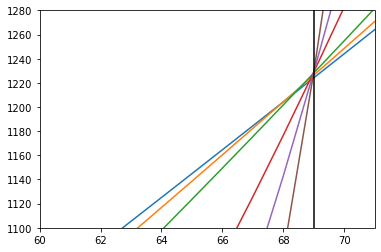

In [15]:
for n in n_range:
    plt.plot(e_range[n].cumsum())
print(emis_profile.sel(year = slice(0,T)).mean(dim = ['model']).sel(experiment = '1pct').sum()['emis'].values)
plt.xlim(60,71)
plt.ylim(1100,1280)
plt.axvline(69, color = 'k')

In [16]:
%%time

GF = G_ds.weighted(model_weights).mean(dim = ['model', 'pulse_type'])
conv_2degC = {}
for n in n_range:
    conv_2degC[n] = signal.convolve(np.array(GF.dropna(dim = 's')), e_range[n][..., None, None],'full')
    conv_2degC[n] = utils.np_to_xr(conv_2degC[n], GF, e_range[n])



CPU times: user 4.77 s, sys: 2.29 s, total: 7.06 s
Wall time: 7.08 s


In [17]:
conv_2degC_ds = xr.concat([conv_2degC[n] for n in conv_2degC.keys()], pd.Index([n for n in conv_2degC.keys()], name='polyfit'), coords='minimal')


## Specific locations

In [18]:
gmean_vline = np.abs((conv_ds.weighted(A).mean(dim = ['lat','lon']).weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)).where(
    np.abs((conv_ds.weighted(A).mean(dim = ['lat','lon']).weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)) == 
    np.abs((conv_ds.weighted(A).mean(dim = ['lat','lon']).weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)).min(), drop = True)['s'].values

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[2.16577331 2.17070097 2.17367769 2.09859923 1.89487939 1.4952252
 2.68540066]
[2.08198852 2.09678543 2.11445195 2.06301484 1.85717517 1.4572606
 2.35337096]
[1.36370824 1.35532331 1.33699221 1.2328087  1.10742855 0.89955502
 1.66480291]
[1.58713819 1.58439582 1.57461162 1.47582807 1.31349407 1.03154411
 1.77603013]


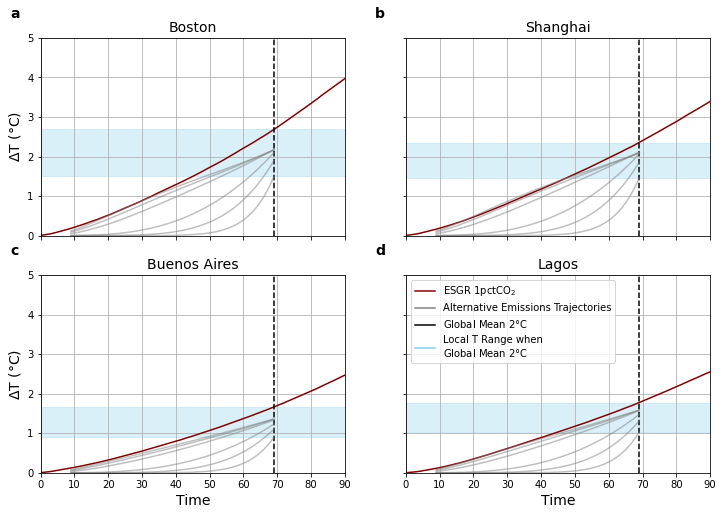

In [19]:
fig, [[ax1, ax2],[ ax3, ax4]] = plt.subplots(2,2, figsize = [12,8], sharex = True, sharey = True)

##############################################################
lat_lon = {'lat': 42.3, 'lon': 360-71.1}
#1pct
conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').plot(ax = ax1, color = type_color['emulator_1pct'], label = ' 1pctCO$_2$')
#ax1.fill_between(np.arange(0,551),conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').roll(s = -5), conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').roll(s = 5), alpha = .1, color = type_color['emulator_1pct'])
plt.xlim(0,90)
ax1.set_title('Boston', fontsize = 14)
ax1.set_xlabel('', fontsize = 14)
ax1.set_ylabel('$\Delta$T ($\degree$C)', fontsize = 14)

#global 2 degree C
gmean_vline = np.abs((conv_ds.sel(experiment = '1pct').weighted(A).mean(dim = ['lat','lon']).weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)).where(
    np.abs((conv_ds.sel(experiment = '1pct').weighted(A).mean(dim = ['lat','lon']).weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)) == 
    np.abs((conv_ds.sel(experiment = '1pct').weighted(A).mean(dim = ['lat','lon']).weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)).min(), drop = True)['s'].values
ax1.axvline(gmean_vline, linestyle = "--", color = 'k')
#local time when global 2 degree C
gmean_hline = conv_ds.sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(experiment = '1pct').sel(s = gmean_vline).values

#similar cumulative emissions
for n in n_range:
    ax1.plot(conv_2degC_ds.sel(s = slice(0,69)).rolling(s = 10).mean('s').sel(polyfit = n).sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest'), color = 'grey', alpha = 0.5)
plt.ylim(0,5)

# ax1.fill_between(np.arange(5,70), conv_2degC_ds.sel(polyfit = 1/8).sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').sel(s = slice(5,69)), 
#                  conv_2degC_ds.sel(polyfit = 8).sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').sel(s = slice(5,69)),
#                  color = 'grey', alpha = .1)


local_mean_spread = np.concatenate([conv_2degC_ds.rolling(s = 10).mean('s').sel(s = gmean_vline).sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').values.reshape(6,), gmean_hline,
                                   #conv_2degC_ds.sel(polyfit = 8).sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').roll(s = 5).sel(s = 68).values.reshape(1,),
                                   #conv_2degC_ds.sel(polyfit = 1/8).sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').roll(s = -5).sel(s = 68).values.reshape(1,)
                                   ])
print(local_mean_spread)
local_max = np.max(local_mean_spread)
local_min = np.min(local_mean_spread)
ax1.axhspan(local_max, local_min, color = 'skyblue', alpha = .3)

##############################################################
lat_lon = {'lat': 31.2, 'lon': 121.5}

#ds_dif['tas'].sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').plot(ax = ax2, color = type_color['emulator_1pct'], label = 'Convolution')
conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').plot(ax = ax2, color = type_color['emulator_1pct'], label = ' 1pctCO$_2$')
#ax2.fill_between(np.arange(0,551),conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').roll(s = -5), conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').roll(s = 5), alpha = .1, color = type_color['emulator_1pct'])
plt.xlim(0,90)
plt.legend()
ax2.set_title('Shanghai', fontsize = 14)
ax2.set_xlabel('', fontsize = 14)
ax2.set_ylabel('', fontsize = 14)

#global 2 degree C
ax2.axvline(gmean_vline, linestyle = "--", color = 'k')
#local time when global 2 degree C
gmean_hline = conv_ds.sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(experiment = '1pct').sel(s = gmean_vline).values

#similar cumulative emissions
for n in n_range:
    ax2.plot(conv_2degC_ds.sel(s = slice(0,69)).rolling(s = 10).mean('s').sel(polyfit = n).sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest'), color = 'grey', alpha = 0.5)
plt.ylim(0,5)

# ax2.fill_between(np.arange(5,70), conv_2degC_ds.sel(polyfit = 1/8).sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').sel(s = slice(5,69)), 
#                  conv_2degC_ds.sel(polyfit = 8).sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').sel(s = slice(5,69)),
#                  color = 'grey', alpha = .1)

local_mean_spread = np.concatenate([conv_2degC_ds.rolling(s = 10).mean('s').sel(s = gmean_vline).sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').values.reshape(6,), gmean_hline,
                                  # conv_2degC_ds.sel(polyfit = 8).sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').roll(s = 5).sel(s = 68).values.reshape(1,),
                                  # conv_2degC_ds.sel(polyfit = 1/8).sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').roll(s = -5).sel(s = 68).values.reshape(1,)
                                   ])
print(local_mean_spread)
local_max = np.max(local_mean_spread)
local_min = np.min(local_mean_spread)
ax2.axhspan(local_max, local_min, color = 'skyblue', alpha = .3)
##############################################################
lat_lon = {'lat': 34.6, 'lon': 360-58.4}

#ds_dif['tas'].sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').plot(ax = ax3, color = type_color['emulator_1pct'], label = 'Convolution')
conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').plot(ax = ax3, color = type_color['emulator_1pct'], label = ' 1pctCO$_2$')
#ax3.fill_between(np.arange(0,551),conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').roll(s = -5), conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').roll(s = 5), alpha = .1, color = type_color['emulator_1pct'])
plt.xlim(0,90)
ax3.set_title('Buenos Aires', fontsize = 14)
ax3.set_xlabel('Time', fontsize = 14)
ax3.set_ylabel('$\Delta$T ($\degree$C)', fontsize = 14)

#global 2 degree C
ax3.axvline(gmean_vline, linestyle = "--", color = 'k')
#local time when global 2 degree C
gmean_hline = conv_ds.sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(experiment = '1pct').sel(s = gmean_vline).values

#similar cumulative emissions
for n in n_range:
    ax3.plot(conv_2degC_ds.sel(s = slice(0,69)).rolling(s = 10).mean('s').sel(polyfit = n).sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest'), color = 'grey', alpha = 0.5)
plt.ylim(0,5)

# ax3.fill_between(np.arange(5,70), conv_2degC_ds.sel(polyfit = 1/8).sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').sel(s = slice(5,69)), 
#                  conv_2degC_ds.sel(polyfit = 8).sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').sel(s = slice(5,69)),
#                  color = 'grey', alpha = .1)

local_mean_spread = np.concatenate([conv_2degC_ds.rolling(s = 10).mean('s').sel(s = gmean_vline).sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').values.reshape(6,), gmean_hline,
                                  # conv_2degC_ds.sel(polyfit = 8).sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').roll(s = 5).sel(s = 68).values.reshape(1,),
                                  # conv_2degC_ds.sel(polyfit = 1/8).sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').roll(s = -5).sel(s = 68).values.reshape(1,)
                                   ])
print(local_mean_spread)
local_max = np.max(local_mean_spread)
local_min = np.min(local_mean_spread)
ax3.axhspan(local_max, local_min, color = 'skyblue', alpha = .3)

##############################################################
lat_lon = {'lat': 6.5, 'lon': 3.4}

conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').plot(ax = ax4, color = type_color['emulator_1pct'], label = 'ESGR 1pctCO$_2$')
#ax4.fill_between(np.arange(0,551),conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').roll(s = -5), conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').roll(s = 5), alpha = .1, color = type_color['emulator_1pct'])
plt.xlim(0,90)
plt.ylim(0,8)
ax4.set_title('Lagos', fontsize = 14)
ax4.set_xlabel('Time', fontsize = 14)
ax4.set_ylabel('', fontsize = 14)

#global 2 degree C
ax4.axvline(gmean_vline, linestyle = "--", color = 'k')
#local temp when global 2 degree C
gmean_hline = conv_ds.sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(experiment = '1pct').sel(s = gmean_vline).values



#similar cumulative emissions
for n in n_range:
    ax4.plot(conv_2degC_ds.sel(s = slice(0,69)).rolling(s = 10).mean('s').sel(polyfit = n).sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest'), color = 'grey', alpha = 0.5)

# ax4.fill_between(np.arange(5,70), conv_2degC_ds.sel(polyfit = 8).sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').sel(s = slice(5,69)), 
#                 conv_2degC_ds.sel(polyfit = 1/8).sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').sel(s = slice(5,69)),
#                  color = 'grey', alpha = .1)

local_mean_spread = np.concatenate([conv_2degC_ds.rolling(s = 10).mean('s').sel(s = gmean_vline).sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').values.reshape(6,), gmean_hline,
                                  # conv_2degC_ds.sel(polyfit = 8).sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').roll(s = 5).sel(s = 68).values.reshape(1,),
                                  # conv_2degC_ds.sel(polyfit = 1/8).sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').roll(s = -5).sel(s = 68).values.reshape(1,)
                                   ])
print(local_mean_spread)
local_max = np.max(local_mean_spread)
local_min = np.min(local_mean_spread)
ax4.axhspan(local_max, local_min, color = 'skyblue', alpha = .3)

plt.ylim(0,5)


####### legend ##########
handles, labels = plt.gca().get_legend_handles_labels()
#local_2c =  Line2D([0], [0], label='Local 2$\degree$C', color='C0')  
global_2c = Line2D([0], [0], label='Global Mean 2$\degree$C', color='k')
local_global_2c = Line2D([0], [0], label='Local T Range when\nGlobal Mean 2$\degree$C', color='skyblue')
alt_emis = Line2D([0], [0], label='Alternative Emissions Trajectories', color='grey')


handles.extend([alt_emis, global_2c,local_global_2c])

#subplot labels, a, b, c, d
alpha_labels = iter(alphabet)
for ax in [ax1, ax2, ax3, ax4]:
    label = next(alpha_labels)
    ax.text(x = -0.1, y = 1.1, s = label, transform=ax.transAxes, fontweight="bold", fontsize = 14)

    
plt.legend(handles=handles)

ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
plt.savefig('figures/extra/figure5_locations_time.png', bbox_inches = 'tight', dpi = 300)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


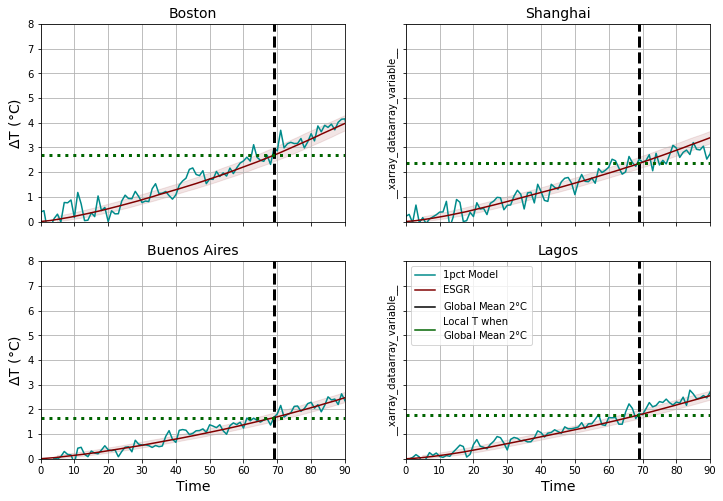

In [20]:
fig, [[ax1, ax2],[ ax3, ax4]] = plt.subplots(2,2, figsize = [12,8], sharex = True, sharey = True)

lat_lon = {'lat': 42.3, 'lon': 360-71.1}

ds_dif['tas'].sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').plot(ax = ax1, color = type_color['model_1pct'], label = 'Convolution')
conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').plot(ax = ax1, color = type_color['emulator_1pct'], label = '1pct Model')
ax1.fill_between(np.arange(0,636),conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').roll(s = -5), conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').roll(s = 5), alpha = .1, color = type_color['emulator_1pct'])
plt.xlim(0,90)
ax1.set_title('Boston', fontsize = 14)
ax1.set_xlabel('', fontsize = 14)
ax1.set_ylabel('$\Delta$T ($\degree$C)', fontsize = 14)
vline = np.abs((conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)).where(
    np.abs((conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)) == 
    np.abs((conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)).min(), drop = True)['s'].values

gmean_vline = np.abs((conv_ds.sel(experiment = '1pct').weighted(A).mean(dim = ['lat','lon']).weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)).where(
    np.abs((conv_ds.sel(experiment = '1pct').weighted(A).mean(dim = ['lat','lon']).weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)) == 
    np.abs((conv_ds.sel(experiment = '1pct').weighted(A).mean(dim = ['lat','lon']).weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)).min(), drop = True)['s'].values
ax1.axvline(gmean_vline, linestyle = "--", color = 'k', linewidth = 3)
gmean_hline = conv_ds.sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(experiment = '1pct').sel(s = gmean_vline).values
ax1.axhline(y = gmean_hline, color = 'darkgreen', linestyle = ':', linewidth = 3)

##############################################################
lat_lon = {'lat': 31.2, 'lon': 121.5}

ds_dif['tas'].sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').plot(ax = ax2, color = type_color['model_1pct'], label = 'Convolution')
conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').plot(ax = ax2, color = type_color['emulator_1pct'], label = '1pct Model')
ax2.fill_between(np.arange(0,636),conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').roll(s = -5), conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').roll(s = 5), alpha = .1, color = type_color['emulator_1pct'])
plt.xlim(0,90)
plt.legend()
ax2.set_title('Shanghai', fontsize = 14)
ax2.set_xlabel('', fontsize = 14)
vline = np.abs((conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)).where(
    np.abs((conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)) == 
    np.abs((conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)).min(), drop = True)['s'].values
# ax2.axvline(vline,
#             linestyle = ':')
# ax2.axvspan(vline -5, vline +5, 0,10, alpha = 0.1)
ax2.axvline(gmean_vline, linestyle = "--", color = 'k', linewidth = 3)
gmean_hline = conv_ds.sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(experiment = '1pct').sel(s = gmean_vline).values
ax2.axhline(y = gmean_hline, color = 'darkgreen', linestyle = ':', linewidth = 3)

##############################################################
lat_lon = {'lat': 34.6, 'lon': 360-58.4}

ds_dif['tas'].sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').plot(ax = ax3, color = type_color['model_1pct'], label = 'Convolution')
conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').plot(ax = ax3, color = type_color['emulator_1pct'], label = '1pct Model')
ax3.fill_between(np.arange(0,636),conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').roll(s = -5), conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').roll(s = 5), alpha = .1, color = type_color['emulator_1pct'])
plt.xlim(0,90)
ax3.set_title('Buenos Aires', fontsize = 14)
ax3.set_xlabel('Time', fontsize = 14)
ax3.set_ylabel('$\Delta$T ($\degree$C)', fontsize = 14)
vline = np.abs((conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)).where(
    np.abs((conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)) == 
    np.abs((conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)).min(), drop = True)['s'].values

ax3.axvline(gmean_vline, linestyle = "--", color = 'k', linewidth = 3)
gmean_hline = conv_ds.sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(experiment = '1pct').sel(s = gmean_vline).values
ax3.axhline(y = gmean_hline, color = 'darkgreen', linestyle = ':', linewidth = 3)


##############################################################
lat_lon = {'lat': 6.5, 'lon': 3.4}

ds_dif['tas'].sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').plot(ax = ax4, color = type_color['model_1pct'], label = '1pct Model')
conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').plot(ax = ax4, color = type_color['emulator_1pct'], label = 'ESGR')
ax4.fill_between(np.arange(0,636),conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').roll(s = -5), conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').roll(s = 5), alpha = .1, color = type_color['emulator_1pct'])
plt.xlim(0,90)
plt.ylim(0,8)
ax4.set_title('Lagos', fontsize = 14)
ax4.set_xlabel('Time', fontsize = 14)
vline = np.abs((conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)).where(
    np.abs((conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)) == 
    np.abs((conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)).min(), drop = True)['s'].values

ax4.axvline(gmean_vline, linestyle = "--", color = 'k', linewidth = 3)
gmean_hline = conv_ds.sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(experiment = '1pct').sel(s = gmean_vline).values
ax4.axhline(y = gmean_hline, color = 'darkgreen', linestyle = ':', linewidth = 3)

handles, labels = plt.gca().get_legend_handles_labels()
#local_2c =  Line2D([0], [0], label='Local 2$\degree$C', color='C0')  
global_2c = Line2D([0], [0], label='Global Mean 2$\degree$C', color='k')
local_global_2c = Line2D([0], [0], label='Local T when\nGlobal Mean 2$\degree$C', color='darkgreen')

handles.extend([global_2c,local_global_2c])

plt.legend(handles=handles)

ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
plt.savefig('figures/talks/figure5_locations_time.png', bbox_inches = 'tight', dpi = 300)

In [54]:
#emissions to get to a level of warming
print(emis_profile.where(ds_dif['model'].isin(model_weights.model.values), drop = True).weighted(model_weights).mean(dim = 'model').sel(year = slice(0,np.squeeze(vline))).sum('year'))


<xarray.Dataset>
Dimensions:     (experiment: 2)
Coordinates:
    depth       float64 0.0
  * experiment  (experiment) object '1000gtc' '1pct'
Data variables:
    emis        (experiment) float64 1.057e+03 1.231e+03


In [55]:
gmean_vline = np.abs((conv_ds.sel(experiment = '1pct').weighted(A).mean(dim = ['lat','lon']).weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)).where(
    np.abs((conv_ds.sel(experiment = '1pct').weighted(A).mean(dim = ['lat','lon']).weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)) == 
    np.abs((conv_ds.sel(experiment = '1pct').weighted(A).mean(dim = ['lat','lon']).weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)).min(), drop = True)['s'].values

lat_lon = {'lat': 42.3, 'lon': 360-71.1}
vline = np.abs((conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)).where(
    np.abs((conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)) == 
    np.abs((conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)).min(), drop = True)['s'].values
gmean_hline = conv_ds.sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(experiment = '1pct').sel(s = slice( float(gmean_vline)-5, float(gmean_vline) +5)).values

print(vline)
print(gmean_hline.mean())


lat_lon = {'lat': 31.2, 'lon': 121.5}

vline = np.abs((conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)).where(
    np.abs((conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)) == 
    np.abs((conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)).min(), drop = True)['s'].values

gmean_hline = conv_ds.sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(experiment = '1pct').sel(s = slice( float(gmean_vline)-5, float(gmean_vline) +5)).values


print(vline)
print(gmean_hline.mean())

lat_lon = {'lat': 34.6, 'lon': 360-58.4}

vline = np.abs((conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)).where(
    np.abs((conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)) == 
    np.abs((conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)).min(), drop = True)['s'].values

gmean_hline = conv_ds.sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(experiment = '1pct').sel(s = slice( float(gmean_vline)-5, float(gmean_vline) +5)).values

print(vline)
print(gmean_hline.mean())


lat_lon = {'lat': 6.5, 'lon': 3.4}


vline = np.abs((conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)).where(
    np.abs((conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)) == 
    np.abs((conv_ds.sel(experiment = '1pct').sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(0,140))-2)).min(), drop = True)['s'].values

gmean_hline = conv_ds.sel(lat = lat_lon['lat'], lon = lat_lon['lon'], method = 'nearest').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(experiment = '1pct').sel(s = slice( float(gmean_vline)-5, float(gmean_vline) +5)).values

print(vline)
print(gmean_hline.mean())


[56]
2.6905081350678017
[61]
2.3567635195252916
[78]
1.667796953158872
[75]
1.778194621448902


## Zero emissions Commitment

In [56]:
t = 80
yr_dif = 10
(conv_ds.sel(experiment = '1000gtc').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = slice(t-yr_dif, t+yr_dif)).mean(dim = 's').weighted(A).mean(dim = ['lat','lon']) - 
conv_ds.sel(experiment = '1000gtc').weighted(model_weights).mean(dim = 'model').mean(dim = 'pulse_type').sel(s = 65).weighted(A).mean(dim = ['lat','lon']))

<xarray.DataArray '__xarray_dataarray_variable__' ()>
array(-0.02757228)
Coordinates:
    experiment  <U7 '1000gtc'
    s           int64 65